# Assess privacy risks on a seq2seq model with TensorFlow Privacy Membership Inference Attacks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/seq2seq_membership_inference_codelab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack/codelabs/seq2seq_membership_inference_codelab.ipynb.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this codelab we'll train a simple translation model on the SATED dataset which consists of sentences grouped together by a "user" (i.e. the person who spoke the sentences). We will then use a "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular user was present in the training set.

## Setup

First, set this notebook's runtime to use a GPU, under Runtime > Change runtime type > Hardware accelerator.

Then, begin importing the necessary libraries.

In [1]:
# Import statements.

import numpy as np
from collections import Counter, defaultdict
from itertools import chain

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec, Input, Embedding, LSTM, Dropout, Dense, Add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

### Install TensorFlow Privacy.

In [2]:
!pip3 install git+https://github.com/tensorflow/privacy

from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

  Cloning https://github.com/tensorflow/privacy to /private/var/folders/z8/yyl7bbz90bx_mcf8y1sghj700000gn/T/pip-req-build-858lr99q
  Created wheel for tensorflow-privacy: filename=tensorflow_privacy-0.5.1-py3-none-any.whl size=144389 sha256=0dcea18c0b4b06c3f19bc765d29a807fd5782fa75c0d27a881c7f1a88de8e3da
  Stored in directory: /private/var/folders/z8/yyl7bbz90bx_mcf8y1sghj700000gn/T/pip-ephem-wheel-cache-hteoqxwl/wheels/2f/fb/b8/7eabbe4b85682ff7e299a9446b36521ed33dd97dff1f1a86ba
Successfully built tensorflow-privacy


## Load the SATED dataset.

Download the SATED dataset from [here.](https://www.cs.cmu.edu/~pmichel1/sated/) We use **English-French** sentence pairs for this codelab.

The code for data-loading is adapted from [csong27/auditing-text-generation/data_loader/load_sated](https://github.com/csong27/auditing-text-generation/blob/master/data_loader/load_sated.py).

In [3]:
# File paths for SATED dataset.

SATED_PATH = 'sated-release-0.9.0/en-fr/'
SATED_TRAIN_ENG = SATED_PATH + 'train.en'
SATED_TRAIN_FR = SATED_PATH + 'train.fr'
SATED_TRAIN_USER = SATED_PATH + 'train.usr'
SATED_DEV_ENG = SATED_PATH + 'dev.en'
SATED_DEV_FR = SATED_PATH + 'dev.fr'
SATED_DEV_USER = SATED_PATH + 'dev.usr'
SATED_TEST_ENG = SATED_PATH + 'test.en'
SATED_TEST_FR = SATED_PATH + 'test.fr'

In [4]:
# Helper methods for preprocessing and loading the SATED dataset.

def load_users(p=SATED_TRAIN_USER):
    """Loads users from the dataset."""
    users = []
    with open(p, 'r', encoding='UTF-8') as f:
        for line in f:
            users.append(line.replace('\n', ''))
    return users


def load_texts(p=SATED_TRAIN_ENG):
    """Loads and adds start and end tokens to sentences."""
    texts = []
    with open(p, 'r', encoding='UTF-8') as f:
        for line in f:
            arr = ['<sos>'] + line.replace('\n', '').split(' ') + ['<eos>']
            words = []
            for w in arr:
                words.append(w)
            texts.append(words)

    return texts


def process_texts(texts, vocabs):
    """Processes sentences according to vocabs i.e. if word is not present
        in the vocab it is replaced with the <unk> token."""
    for t in texts:
        for i, w in enumerate(t):
            if w not in vocabs:
                t[i] = '<unk>'


def process_vocabs(vocabs, num_words=10000):
    """Returns vocabs with num_words amount of most frequent words."""

    counter = Counter(vocabs)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    if num_words is not None:
        count_pairs = count_pairs[:num_words - 1]

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, np.arange(len(words))))
    return word_to_id

### Define data-loading method.

In [5]:
def load_sated_data_by_user(num_users=100, num_words=5000, test_on_user=False, seed=12345):
    """Loads training, validation, and test sets of sentences.

    Sentences in the training set are grouped by the user who spoke the sentences.
    One can specify if sentences need to be grouped in the test set.

    Args:
        num_users: Number of users to include in the training and test sets.
        num_words: Denotes how many of the most frequent words to include in
            the source and target language vocabularies.
        test_on_user: Determines if sentences in the test set will be grouped
            by the user who spoke the sentences.
        seed: Seed for shuffling users in the entire dataset before sampling.

    Returns:
        Training, validation, and test sets of sentences.
    """
    src_users = load_users(SATED_TRAIN_USER)

    # Load training set sentences
    train_src_texts = load_texts(SATED_TRAIN_ENG)
    train_trg_texts = load_texts(SATED_TRAIN_FR)

    # Load validation set sentences
    dev_src_texts = load_texts(SATED_DEV_ENG)
    dev_trg_texts = load_texts(SATED_DEV_FR)

    # Load test set sentences
    test_src_texts = load_texts(SATED_TEST_ENG)
    test_trg_texts = load_texts(SATED_TEST_FR)

    # Shuffle users
    user_counter = Counter(src_users)
    all_users = [tup[0] for tup in user_counter.most_common()]
    np.random.seed(seed)
    np.random.shuffle(all_users)
    np.random.seed(None)

    # Sample users for training and test sets
    train_users = set(all_users[:num_users])
    test_users = set(all_users[num_users: num_users * 2])

    user_src_texts = defaultdict(list)
    user_trg_texts = defaultdict(list)

    test_user_src_texts = defaultdict(list)
    test_user_trg_texts = defaultdict(list)

    # Create training set (and optionally the test set), grouped by user
    for u, s, t in zip(src_users, train_src_texts, train_trg_texts):
        if u in train_users:
            user_src_texts[u].append(s)
            user_trg_texts[u].append(t)
        if test_on_user and u in test_users:
            test_user_src_texts[u].append(s)
            test_user_trg_texts[u].append(t)

    # Create source and target language vocabs for tokenizing sentences
    # Restrict number of words in vocabs to num_words
    src_words = []
    trg_words = []
    for u in train_users:
        src_words += list(chain(*user_src_texts[u]))
        trg_words += list(chain(*user_trg_texts[u]))

    src_vocabs = process_vocabs(src_words, num_words)
    trg_vocabs = process_vocabs(trg_words, num_words)

    # Tokenize sentences in the training set
    for u in train_users:
        process_texts(user_src_texts[u], src_vocabs)
        process_texts(user_trg_texts[u], trg_vocabs)

    # Tokenize sentences in the test set, if grouped by user
    if test_on_user:
        for u in test_users:
            process_texts(test_user_src_texts[u], src_vocabs)
            process_texts(test_user_trg_texts[u], trg_vocabs)

    # Tokenize sentences in the validation set and test set
    process_texts(dev_src_texts, src_vocabs)
    process_texts(dev_trg_texts, trg_vocabs)

    process_texts(test_src_texts, src_vocabs)
    process_texts(test_trg_texts, trg_vocabs)

    # Create source and target language vocabs
    # Include all words since we won't use these for tokenizing anymore
    src_words = []
    trg_words = []
    for u in train_users:
        src_words += list(chain(*user_src_texts[u]))
        trg_words += list(chain(*user_trg_texts[u]))

    src_vocabs = process_vocabs(src_words, None)
    trg_vocabs = process_vocabs(trg_words, None)

    # Return the appropriate training, validation, test sets and source and target vocabs
    if test_on_user:
        return user_src_texts, user_trg_texts, test_user_src_texts, test_user_trg_texts, src_vocabs, trg_vocabs
    else:
        return user_src_texts, user_trg_texts, dev_src_texts, dev_trg_texts, test_src_texts, test_trg_texts,\
               src_vocabs, trg_vocabs

## Define the seq2seq model.

We follow the model architecture specified in [Extreme Adaptation for Personalized Neural Machine Translation (P. Michel, G. Neubig)](https://arxiv.org/pdf/1805.01817.pdf).

The code for the model architecture is adapted from [csong27/auditing-text-generation/sated_nmt](https://github.com/csong27/auditing-text-generation/blob/master/sated_nmt.py).

### Define layers.

In [6]:
def flatten_data(data):
    return np.asarray([w for t in data for w in t]).astype(np.int32)

In [7]:
class Attention(Layer):
    def __init__(self, units,
                 activation='linear',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.supports_masking = True

    def build(self, input_shape):
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('An attention layer should be called '
                             'on a list of 2 inputs.')
        enc_dim = input_shape[0][-1]
        dec_dim = input_shape[1][-1]

        self.W_enc = self.add_weight(shape=(enc_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='W_enc',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        self.W_dec = self.add_weight(shape=(dec_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='W_dec',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        self.W_score = self.add_weight(shape=(self.units, 1),
                                       initializer=self.kernel_initializer,
                                       name='W_score',
                                       regularizer=self.kernel_regularizer,
                                       constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias_enc = self.add_weight(shape=(self.units,),
                                            initializer=self.bias_initializer,
                                            name='bias_enc',
                                            regularizer=self.bias_regularizer,
                                            constraint=self.bias_constraint)
            self.bias_dec = self.add_weight(shape=(self.units,),
                                            initializer=self.bias_initializer,
                                            name='bias_dec',
                                            regularizer=self.bias_regularizer,
                                            constraint=self.bias_constraint)
            self.bias_score = self.add_weight(shape=(1,),
                                              initializer=self.bias_initializer,
                                              name='bias_score',
                                              regularizer=self.bias_regularizer,
                                              constraint=self.bias_constraint)

        else:
            self.bias_enc = None
            self.bias_dec = None
            self.bias_score = None

        self.built = True

    def call(self, inputs, **kwargs):
        if not isinstance(inputs, list) or len(inputs) != 2:
            raise ValueError('An attention layer should be called '
                             'on a list of 2 inputs.')
        encodings, decodings = inputs
        d_enc = K.dot(encodings, self.W_enc)
        d_dec = K.dot(decodings, self.W_dec)

        if self.use_bias:
            d_enc = K.bias_add(d_enc, self.bias_enc)
            d_dec = K.bias_add(d_dec, self.bias_dec)

        if self.activation is not None:
            d_enc = self.activation(d_enc)
            d_dec = self.activation(d_dec)

        enc_seqlen = K.shape(d_enc)[1]
        d_dec_shape = K.shape(d_dec)

        stacked_d_dec = K.tile(d_dec, [enc_seqlen, 1, 1])  # enc time x batch x dec time  x da
        stacked_d_dec = K.reshape(stacked_d_dec, [enc_seqlen, d_dec_shape[0], d_dec_shape[1], d_dec_shape[2]])
        stacked_d_dec = K.permute_dimensions(stacked_d_dec, [2, 1, 0, 3])  # dec time x batch x enc time x da
        tanh_add = K.tanh(stacked_d_dec + d_enc)  # dec time x batch x enc time x da
        scores = K.dot(tanh_add, self.W_score)
        if self.use_bias:
            scores = K.bias_add(scores, self.bias_score)
        scores = K.squeeze(scores, 3)  # batch x dec time x enc time

        weights = K.softmax(scores)  # dec time x batch x enc time
        weights = K.expand_dims(weights)

        weighted_encodings = weights * encodings  # dec time x batch x enc time x h
        contexts = K.sum(weighted_encodings, axis=2)  # dec time x batch x h
        contexts = K.permute_dimensions(contexts, [1, 0, 2])  # batch x dec time x h

        return contexts

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list) and len(input_shape) == 2
        assert input_shape[-1]
        output_shape = list(input_shape[1])
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
class DenseTransposeTied(Layer):
    def __init__(self, units,
                 tied_to=None,  # Enter a layer as input to enforce weight-tying
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DenseTransposeTied, self).__init__(**kwargs)
        self.units = units
        # We add these two properties to save the tied weights
        self.tied_to = tied_to
        self.tied_weights = self.tied_to.weights
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        # We remove the weights and bias because we do not want them to be trainable
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, **kwargs):
        # Return the transpose layer mapping using the explicit weight matrices
        output = K.dot(inputs, K.transpose(self.tied_weights[0]))
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.activation is not None:
            output = self.activation(output)

        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(DenseTransposeTied, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Define batch processing and model creation methods.

In [9]:
def group_texts_by_len(src_texts, trg_texts, bs=20):
    """Groups sentences by their length, so batches can have minimal padding."""
    # Bucket samples by source sentence length
    buckets = defaultdict(list)
    batches = []
    for src, trg in zip(src_texts, trg_texts):
        buckets[len(src)].append((src, trg))

    # Create batches
    for src_len, bucket in buckets.items():
        np.random.shuffle(bucket)
        num_batches = int(np.ceil(len(bucket) * 1.0 / bs))
        for i in range(num_batches):
            cur_batch_size = bs if i < num_batches - 1 else len(bucket) - bs * i
            batches.append(([bucket[i * bs + j][0] for j in range(cur_batch_size)],
                            [bucket[i * bs + j][1] for j in range(cur_batch_size)]))
    return batches

In [10]:
def build_nmt_model(Vs, Vt, demb=128, h=128, drop_p=0.5, tied=True, mask=True, attn=True, l2_ratio=1e-4,
                    training=None, rnn_fn='lstm'):
    """Builds the target machine translation model.

    Args:
        Vs, Vt: Vocab sizes for source, target vocabs.
        demb: Embedding dimension.
        h: Number of hidden units.
        drop_p: Dropout percentage.
        attn: Flag to include attention units.
        rnn_fn: RNN type to use in the model. Can be 'lstm' or 'gru'.
    """
    if rnn_fn == 'lstm':
        rnn = LSTM
    elif rnn_fn == 'gru':
        rnn = LSTM
    else:
        raise ValueError(rnn_fn)

    # Build encoder
    encoder_input = Input((None,), dtype='float32', name='encoder_input')
    if mask:
        encoder_emb_layer = Embedding(Vs + 1, demb, mask_zero=True, embeddings_regularizer=l2(l2_ratio),
                                      name='encoder_emb')
    else:
        encoder_emb_layer = Embedding(Vs, demb, mask_zero=False, embeddings_regularizer=l2(l2_ratio),
                                      name='encoder_emb')

    encoder_emb = encoder_emb_layer(encoder_input)

    # Dropout for encoder
    if drop_p > 0.:
        encoder_emb = Dropout(drop_p)(encoder_emb, training=training)

    encoder_rnn = rnn(h, return_sequences=True, return_state=True, kernel_regularizer=l2(l2_ratio), name='encoder_rnn')
    encoder_rtn = encoder_rnn(encoder_emb)
    encoder_outputs = encoder_rtn[0]
    encoder_states = encoder_rtn[1:]

    # Build decoder
    decoder_input = Input((None,), dtype='float32', name='decoder_input')
    if mask:
        decoder_emb_layer = Embedding(Vt + 1, demb, mask_zero=True, embeddings_regularizer=l2(l2_ratio),
                                      name='decoder_emb')
    else:
        decoder_emb_layer = Embedding(Vt, demb, mask_zero=False, embeddings_regularizer=l2(l2_ratio),
                                      name='decoder_emb')

    decoder_emb = decoder_emb_layer(decoder_input)

    # Dropout for decoder
    if drop_p > 0.:
        decoder_emb = Dropout(drop_p)(decoder_emb, training=training)

    decoder_rnn = rnn(h, return_sequences=True, kernel_regularizer=l2(l2_ratio), name='decoder_rnn')
    decoder_outputs = decoder_rnn(decoder_emb, initial_state=encoder_states)

    if drop_p > 0.:
        decoder_outputs = Dropout(drop_p)(decoder_outputs, training=training)

    if tied:
        final_outputs = DenseTransposeTied(Vt, kernel_regularizer=l2(l2_ratio), name='outputs',
                                           tied_to=decoder_emb_layer, activation='linear')(decoder_outputs)
    else:
        final_outputs = Dense(Vt, activation='linear', kernel_regularizer=l2(l2_ratio), name='outputs')(decoder_outputs)

    # Add attention units
    if attn:
        contexts = Attention(units=h, kernel_regularizer=l2(l2_ratio), name='attention',
                             use_bias=False)([encoder_outputs, decoder_outputs])
        if drop_p > 0.:
            contexts = Dropout(drop_p)(contexts, training=training)

        contexts_outputs = Dense(Vt, activation='linear', use_bias=False, name='context_outputs',
                                 kernel_regularizer=l2(l2_ratio))(contexts)

        final_outputs = Add(name='final_outputs')([final_outputs, contexts_outputs])

    model = Model(inputs=[encoder_input, decoder_input], outputs=[final_outputs])
    return model

In [11]:
# Helper functions for training the translation model.

def words_to_indices(data, vocab, mask=True):
    """
    Converts words to indices according to vocabulary.
    """
    if mask:
        return [[vocab[w] + 1 for w in t] for t in data]
    else:
        return [[vocab[w] for w in t] for t in data]


def pad_texts(texts, eos, mask=True):
    """
    Adds padding to a batch of texts.
    """
    maxlen = max(len(t) for t in texts)
    for t in texts:
        while len(t) < maxlen:
            if mask:
                t.insert(0, 0)
            else:
                t.append(eos)
    return np.asarray(texts, dtype='float32')


def get_perp(user_src_data, user_trg_data, pred_fn, prop=1.0, shuffle=False):
    """
    Returns perplexity scores.
    """
    loss = 0.
    iters = 0.

    indices = np.arange(len(user_src_data))
    n = int(prop * len(indices))

    if shuffle:
        np.random.shuffle(indices)

    for idx in indices[:n]:
        src_text = np.asarray(user_src_data[idx], dtype=np.float32).reshape(1, -1)
        trg_text = np.asarray(user_trg_data[idx], dtype=np.float32)
        trg_input = trg_text[:-1].reshape(1, -1)
        trg_label = trg_text[1:].reshape(1, -1)

        err = pred_fn([src_text, trg_input, trg_label, 0])[0]

        loss += err
        iters += trg_label.shape[1]

    return loss, iters

### Define training method. 

In [12]:
MODEL_PATH = 'checkpoints/'

tf.compat.v1.disable_eager_execution()

def train_sated_nmt(num_users=300, num_words=5000, num_epochs=20, h=128, emb_h=128,
                    l2_ratio=1e-4, lr=0.001, batch_size=32, mask=False, drop_p=0.5,
                    tied=False, rnn_fn='lstm', optim_fn='adam'):
    """Trains the machine translation model.

    Args:
        num_users: Number of users to sample from the dataset.
        num_words: Size of vocabulary.
        h: Number of hidden units.
        emb_h: Embedding dimension.
        l2_ratio: Regularization term.
        lr: Learning rate.
        drop_p: Dropout percentage.
        tied: Flag to use DenseTransposeTied or Dense layer for the model's output layer.
        rnn_fn: Can be 'lstm' or 'gru'.
        optim_fn: Can be 'adam' or 'mom_sgd'.
    """
    # Load dataset for training
    user_src_texts, user_trg_texts, dev_src_texts, dev_trg_texts, test_src_texts, test_trg_texts, \
    src_vocabs, trg_vocabs = load_sated_data_by_user(num_users, num_words, test_on_user=False)
    train_src_texts, train_trg_texts = [], []

    users = sorted(user_src_texts.keys())

    for i, user in enumerate(users):
        train_src_texts += user_src_texts[user]
        train_trg_texts += user_trg_texts[user]

    # Convert words to indices based on the source and target vocabs
    train_src_texts = words_to_indices(train_src_texts, src_vocabs, mask=mask)
    train_trg_texts = words_to_indices(train_trg_texts, trg_vocabs, mask=mask)
    dev_src_texts = words_to_indices(dev_src_texts, src_vocabs, mask=mask)
    dev_trg_texts = words_to_indices(dev_trg_texts, trg_vocabs, mask=mask)

    # Vocab lengths for source and target language vocabularies.
    Vs = len(src_vocabs)
    Vt = len(trg_vocabs)

    # Build model
    model = build_nmt_model(Vs=Vs, Vt=Vt, mask=mask, drop_p=drop_p, h=h, demb=emb_h, tied=tied, l2_ratio=l2_ratio,
                            rnn_fn=rnn_fn)
    src_input_var, trg_input_var = model.inputs
    prediction = model.output

    trg_label_var = K.placeholder((None, None), dtype='float32')

    # Define loss
    loss = K.sparse_categorical_crossentropy(trg_label_var, prediction, from_logits=True)
    loss = K.mean(K.sum(loss, axis=-1))

    # Define optimizer
    if optim_fn == 'adam':
        optimizer = Adam(learning_rate=lr, clipnorm=5.)
    elif optim_fn == 'mom_sgd':
        optimizer = SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError(optim_fn)
    updates = optimizer.get_updates(loss, model.trainable_weights)

    # Define train and prediction functions
    train_fn = K.function(inputs=[src_input_var, trg_input_var, trg_label_var, K.learning_phase()], outputs=[loss],
                          updates=updates)
    pred_fn = K.function(inputs=[src_input_var, trg_input_var, trg_label_var, K.learning_phase()], outputs=[loss])

    # Pad batches to same length
    train_prop = 0.2
    batches = []
    for batch in group_texts_by_len(train_src_texts, train_trg_texts, bs=batch_size):
        src_input, trg_input = batch
        src_input = pad_texts(src_input, src_vocabs['<eos>'], mask=mask)
        trg_input = pad_texts(trg_input, trg_vocabs['<eos>'], mask=mask)
        batches.append((src_input, trg_input))

    # Train machine translation model
    print("Training NMT model...")
    for epoch in range(num_epochs):
        np.random.shuffle(batches)

        for batch in batches:
            src_input, trg_input = batch
            _ = train_fn([src_input, trg_input[:, :-1], trg_input[:, 1:], 1])[0]

        train_loss, train_it = get_perp(train_src_texts, train_trg_texts, pred_fn, shuffle=True, prop=train_prop)
        test_loss, test_it = get_perp(dev_src_texts, dev_trg_texts, pred_fn)

        print("Epoch {}, train loss={:.3f}, train perp={:.3f}, test loss={:.3f}, test perp={:.3f}".format(
            epoch,
            train_loss / len(train_src_texts) / train_prop,
            np.exp(train_loss / train_it),
            test_loss / len(dev_src_texts),
            np.exp(test_loss / test_it)))

    fname = 'sated_nmt'

    # Save model
    model.save(MODEL_PATH + '{}_{}.h5'.format(fname, num_users))
    print(f"Target model saved to {MODEL_PATH + '{}_{}.h5'.format(fname, num_users)}.")
    K.clear_session()

## Train the seq2seq model.

In [13]:
# Define parameters for data-loading
num_users = 300
num_words = 5000

# Define hyperparameters for target model
lr = 0.001
h = 128
emb_h = 128
num_epochs = 30
batch_size = 20
drop_p = 0.5
rnn_fn = 'lstm'
optim_fn = 'adam'

train_sated_nmt(lr=lr, h=h, emb_h=emb_h, num_epochs=num_epochs,
                num_users=num_users, batch_size=batch_size,
                drop_p=drop_p, rnn_fn=rnn_fn, optim_fn=optim_fn)

## Calculate logits and labels for the training and test sets.

We will use these values later in the membership inference attack to separate training and test samples.

In [14]:
# Load the train and test sets grouped by user
user_src_texts, user_trg_texts, test_user_src_texts, test_user_trg_texts, src_vocabs, trg_vocabs \
    = load_sated_data_by_user(num_users, num_words, test_on_user=True)

train_users = sorted(user_src_texts.keys())
train_src_texts, train_trg_texts = [], []
for user in train_users:
    user_src_text = words_to_indices(user_src_texts[user], src_vocabs, mask=False)
    user_trg_text = words_to_indices(user_trg_texts[user], trg_vocabs, mask=False)
    train_src_texts.append(user_src_text)
    train_trg_texts.append(user_trg_text)

test_users = sorted(test_user_src_texts.keys())
test_src_texts, test_trg_texts = [], []
for user in test_users:
    user_src_text = words_to_indices(test_user_src_texts[user], src_vocabs, mask=False)
    user_trg_text = words_to_indices(test_user_trg_texts[user], trg_vocabs, mask=False)
    test_src_texts.append(user_src_text)
    test_trg_texts.append(user_trg_text)

In [15]:
# Get prediction function of the translation model
model = build_nmt_model(Vs=num_words, Vt=num_words, mask=False, drop_p=0., h=h, demb=emb_h, tied=False)
model_path = 'sated_nmt'
model.load_weights(MODEL_PATH + '{}_{}.h5'.format(model_path, num_users))
src_input_var, trg_input_var = model.inputs
prediction = model.output
trg_label_var = K.placeholder((None, None), dtype='float32')
prediction = K.softmax(prediction)
pred_fn = K.function([src_input_var, trg_input_var, trg_label_var, K.learning_phase()], [prediction])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
# Generator for loading logits by user
def get_logits(src_texts, trg_texts):
    for user_src_texts, user_trg_texts in zip(src_texts, trg_texts):
        user_trg_logits = []

        sentence_indices = np.arange(len(user_trg_texts))
        for idx in sentence_indices:
            src_sentence = np.asarray(user_src_texts[idx], dtype=np.float32).reshape(1, -1)
            trg_sentence = np.asarray(user_trg_texts[idx], dtype=np.float32)
            trg_input = trg_sentence[:-1].reshape(1, -1)
            trg_label = trg_sentence[1:].reshape(1, -1)
            trg_logits = pred_fn([src_sentence, trg_input, trg_label, 0])[0][0]
            user_trg_logits.append(trg_logits)

        yield np.array(user_trg_logits, dtype=object)

In [17]:
# Generator for loading labels by user.
def get_labels(trg_texts):
    for user_trg_texts in trg_texts:
        user_trg_labels = []

        for sentence in user_trg_texts:
            trg_sentence = np.asarray(sentence, dtype=np.float32)
            trg_label = trg_sentence[1:]
            user_trg_labels.append(trg_label)

        yield np.array(user_trg_labels, dtype=object)

## Run membership inference attacks.


In [20]:
n_train = 50
n_test = 50

logits_train_gen = get_logits(train_src_texts[:n_train], train_trg_texts[n_train])
logits_test_gen = get_logits(test_src_texts[:n_test], test_trg_texts[:n_test])
labels_train_gen = get_labels(train_trg_texts[:n_train])
labels_test_gen = get_labels(test_trg_texts[:n_test])

Best-performing attacks over all slices
  LOGISTIC_REGRESSION achieved an AUC of 1.00 on slice Entire dataset
  LOGISTIC_REGRESSION achieved an advantage of 1.00 on slice Entire dataset


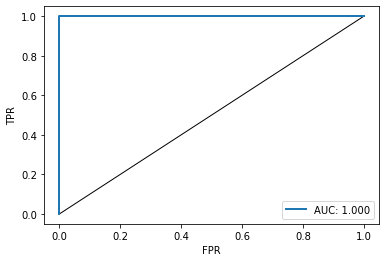

In [21]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.seq2seq_mia import Seq2SeqAttackInputData, \
    run_seq2seq_attack
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

attack_input = Seq2SeqAttackInputData(
    logits_train = logits_train_gen,
    logits_test = logits_test_gen,
    labels_train = labels_train_gen,
    labels_test = labels_test_gen,
    vocab_size = num_words,
    train_size = n_train,
    test_size = n_test
)

# Run several attacks for different data slices
attack_result = run_seq2seq_attack(attack_input)

# Plot the ROC curve of the best classifier
fig = plotting.plot_roc_curve(attack_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attack_result.summary())

# Print metadata of the target model
print(attack_result.privacy_report_metadata)